## Analysis of Judge Model Results

This notebook compares how **different judge models** evaluate the **gpt-4o user proxy** across datasets.

In [1]:
import sys
import os

sys.path.append("../")
os.chdir("../")

In [2]:
import yaml
from mirrorbench.io.paths import Paths

In [3]:
CONFIG_DIRPATH = 'configs'
TARGET_USER_PROXY = 'gpt-4o'  # We analyze gpt-4o user proxy only
TARGET_DATASET = 'chatbot_arena_mirror'  # Focus on chatbot_arena only

paths = Paths.default()

## Collect Runs for gpt-4o Proxy on Chatbot Arena

We collect runs where:
- User proxy is gpt-4o
- Dataset is chatbot_arena_mirror
- Different judge models are used

In [4]:
run_names = []

for dirpath, _, filenames in os.walk(CONFIG_DIRPATH):
    for filename in filenames:
        if not filename.endswith('.yaml'):
            continue
        with open(os.path.join(dirpath, filename), 'r') as f:
            run_config = yaml.safe_load(f)
        name = run_config['run']['name']
        
        # Only include runs with gpt-4o as user proxy AND chatbot_arena dataset
        if f'-{TARGET_USER_PROXY}-user-' in name and TARGET_DATASET in name:
            run_names.append(name)

print(f"Found {len(run_names)} runs with {TARGET_USER_PROXY} user proxy on {TARGET_DATASET}:")
for name in run_names:
    print(f"  - {name}")

Found 4 runs with gpt-4o user proxy on chatbot_arena_mirror:
  - chatbot_arena_mirror-gpt-4o-user-gpt-4o-assistant-gpt-4o-judge
  - chatbot_arena_mirror-gpt-4o-user-gpt-4o-assistant-gpt-5-judge
  - chatbot_arena_mirror-gpt-4o-user-gpt-4o-assistant-claude-4-sonnet-judge
  - chatbot_arena_mirror-gpt-4o-user-gpt-4o-assistant-gemini-2.5-pro-judge


In [5]:
results_list = []

for run_name in run_names:
    results = paths.load_run_summary(run_name)
    assert "aggregates" in results, f"Aggregates missing in {run_name}"
    results_list.append(results)

print(f"Loaded {len(results_list)} evaluation results for {TARGET_DATASET}.")

Loaded 4 evaluation results for chatbot_arena_mirror.


In [6]:
# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

print("Plotting libraries imported successfully.")

Plotting libraries imported successfully.


---

# Publication-Quality Plots for Judge Comparison

Comparing how different judge models evaluate the gpt-4o user proxy.

---

In [7]:
def set_publication_style():
    """Set publication-quality plot styling."""
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update({
        'font.size': 11,
        'font.family': 'sans-serif',
        'axes.labelsize': 12,
        'axes.titlesize': 13,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.dpi': 100,  # Screen preview
        'savefig.dpi': 300,  # High-res save
        'savefig.bbox': 'tight',
        'pdf.fonttype': 42,  # TrueType fonts for editability
        'ps.fonttype': 42,
        'axes.spines.top': False,
        'axes.spines.right': False,
    })

set_publication_style()
print("Publication style set.")

Publication style set.


In [8]:
from matplotlib.colors import LinearSegmentedColormap

# Create custom colormap for "0 is best" metrics
# Green at center (0), red/orange at both extremes
def create_zero_centered_colormap():
    """
    Create a colormap where:
    - Center (0) = Green (best)
    - Extremes (both + and -) = Red/Orange (worst)
    
    This is different from standard diverging colormaps which go:
    Red (negative) → White/Yellow (0) → Green (positive)
    
    Instead, this goes:
    Red (very negative) → Green (0) → Red (very positive)
    """
    # Define colors: red → orange → yellow → green → yellow → orange → red
    colors = [
        '#d73027',  # Red (far negative)
        '#fc8d59',  # Orange
        '#fee090',  # Yellow
        '#91cf60',  # Light green
        '#1a9850',  # Green (at 0 - best!)
        '#91cf60',  # Light green  
        '#fee090',  # Yellow
        '#fc8d59',  # Orange
        '#d73027',  # Red (far positive)
    ]
    
    n_bins = 256
    cmap = LinearSegmentedColormap.from_list('zero_centered', colors, N=n_bins)
    return cmap

# Create the colormap
ZERO_CENTERED_CMAP = create_zero_centered_colormap()
print("✓ Created custom zero-centered colormap (green=0, red=extremes)")

✓ Created custom zero-centered colormap (green=0, red=extremes)


In [9]:
def extract_judge_name(run_name):
    """
    Extract judge model name from run name.
    
    Example:
    "chatbot_arena_mirror-gpt-4o-user-gpt-4o-assistant-gpt-4o-judge" -> "gpt-4o"
    "chatbot_arena_mirror-gpt-4o-user-gpt-4o-assistant-claude-3.7-judge" -> "claude-3.7"
    """
    # Extract the part after last "-assistant-" and before "-judge"
    if "-assistant-" in run_name and "-judge" in run_name:
        judge_part = run_name.split("-assistant-")[-1].replace("-judge", "")
        return judge_part
    return run_name

def get_metric_value(agg, metric_name):
    """
    Extract the appropriate metric value based on metric type.
    
    Rules:
    1. For PI-Pairwise: Return (mean - 0.5) as signed value
    2. For all other metrics: Use raw mean
    """
    base_mean = agg['mean']
    
    # For PI-Pairwise, compute signed difference from 0.5
    if 'pi_pairwise' in metric_name:
        return base_mean - 0.5
    
    # For all other metrics, use raw mean
    return base_mean

def build_metrics_dataframe(results_list, metric_names):
    """
    Build a tidy DataFrame for plotting.
    
    Returns DataFrame with columns:
    - judge: judge model name
    - metric: metric name
    - mean: metric mean (with PI as signed difference from 0.5)
    - ci: confidence interval
    - std: standard deviation
    """
    rows = []
    
    for result in results_list:
        # Extract judge name from run_id
        run_id = result['run']['run_id']
        judge = extract_judge_name(run_id)
        
        # Extract metrics
        for agg in result['aggregates']:
            metric_name = agg['metric_name']
            if metric_name in metric_names:
                rows.append({
                    'judge': judge,
                    'metric': metric_name,
                    'mean': get_metric_value(agg, metric_name),
                    'ci': agg['confidence_interval'],
                    'std': agg['standard_deviation'],
                    'sample_size': agg['sample_size']
                })
    
    return pd.DataFrame(rows)

## Configuration: Metrics to Include in Paper

In [10]:
# Modular metric configuration - JUDGE METRICS ONLY
JUDGE_METRICS = [
    'metric:judge/gteval',
    'metric:judge/pi_pairwise', 
    'metric:judge/rubric_and_reason',
]

# Metric labels for plots
# Note: Arrows for "higher is better", explicit note for PI-Pairwise
METRIC_LABELS = {
    'metric:judge/gteval': 'GTEval (↑)',
    'metric:judge/pi_pairwise': 'PI $\Delta w$ (↑)',  # Clarify in title
    'metric:judge/rubric_and_reason': 'RNR (↑)',
}

print(f"Judge metrics (n={len(JUDGE_METRICS)}): {[METRIC_LABELS[m] for m in JUDGE_METRICS]}")
print(f"\nMetric scoring:")
print(f"  GTEval: raw mean (↑ higher is better)")
print(f"  PI-Pairwise: mean - 0.5 (0 is best - indistinguishable)")
print(f"  RNR: raw mean (↑ higher is better)")

Judge metrics (n=3): ['GTEval (↑)', 'PI $\\Delta w$ (↑)', 'RNR (↑)']

Metric scoring:
  GTEval: raw mean (↑ higher is better)
  PI-Pairwise: mean - 0.5 (0 is best - indistinguishable)
  RNR: raw mean (↑ higher is better)


<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:12: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_137412/3652353595.py:12: SyntaxWarning: invalid escape sequence '\D'
  'metric:judge/pi_pairwise': 'PI $\Delta w$ (↑)',  # Clarify in title


In [11]:
# Build DataFrame for judge metrics only
df_judge = build_metrics_dataframe(results_list, JUDGE_METRICS)

print(f"Judge metrics DataFrame: {len(df_judge)} rows")
print(f"\nJudge models: {sorted(df_judge['judge'].unique())}")
print(f"Metrics: {sorted(df_judge['metric'].unique())}")

# Compute global judge ordering based on judge metrics only
print("\n" + "="*60)
print("Computing judge ordering based on judge metrics...")
print("="*60)

GLOBAL_JUDGE_ORDER = df_judge.groupby('judge')['mean'].apply(
    lambda x: x.abs().mean()  # Average absolute value across judge metrics
).sort_values(ascending=True).index.tolist()

print(f"\nJudge order (best to worst):") 
for i, judge in enumerate(GLOBAL_JUDGE_ORDER, 1):
    avg_abs = df_judge[df_judge['judge'] == judge]['mean'].abs().mean()
    print(f"  {i}. {judge:30s} (avg |score|: {avg_abs:.3f})")

Judge metrics DataFrame: 12 rows

Judge models: ['claude-4-sonnet', 'gemini-2.5-pro', 'gpt-4o', 'gpt-5']
Metrics: ['metric:judge/gteval', 'metric:judge/pi_pairwise', 'metric:judge/rubric_and_reason']

Computing judge ordering based on judge metrics...

Judge order (best to worst):
  1. gemini-2.5-pro                 (avg |score|: 0.439)
  2. claude-4-sonnet                (avg |score|: 0.476)
  3. gpt-5                          (avg |score|: 0.646)
  4. gpt-4o                         (avg |score|: 0.700)


## Single-Column Plot for Paper

Compact vertical layout showing 3 judge metrics for chatbot_arena.

Creating compact horizontal judge comparison plot...


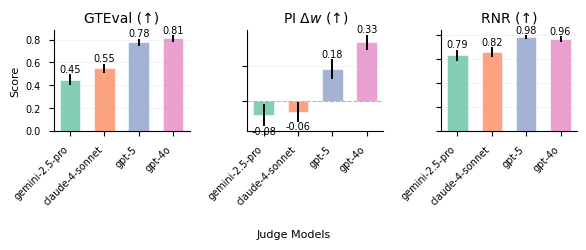

In [12]:
def plot_compact_horizontal_bars(df, metrics_list, metric_labels, judge_order=None,
                                  figsize=(6.0, 2.5)):
    """
    Create compact horizontal bar chart with metrics side-by-side (1 row × N columns).
    Perfect for single-column paper layout with space constraints.
    Shows mean values on top of each bar for better legibility.
    
    Parameters:
    -----------
    figsize : tuple
        Default (7.5, 2.5) fits well in single-column format (~3.5 inches wide for papers)
        Adjust height (2nd value) if needed: (7.5, 2.0) for more compact, (7.5, 3.0) for more space
    """
    n_metrics = len(metrics_list)
    
    # Create figure with horizontal layout (1 row, N columns)
    fig, axes = plt.subplots(1, n_metrics, figsize=figsize)
    if n_metrics == 1:
        axes = [axes]
    
    # Determine judge order
    if judge_order is None:
        judge_scores = df.groupby('judge')['mean'].apply(
            lambda x: x.abs().mean()
        ).sort_values(ascending=True)
        CONSISTENT_JUDGE_ORDER = judge_scores.index.tolist()
    else:
        CONSISTENT_JUDGE_ORDER = judge_order
    
    # Color palette for judges
    colors = sns.color_palette("Set2", n_colors=len(CONSISTENT_JUDGE_ORDER))
    judge_colors = {j: c for j, c in zip(CONSISTENT_JUDGE_ORDER, colors)}
    
    for idx, metric in enumerate(metrics_list):
        ax = axes[idx]
        df_metric = df[df['metric'] == metric]
        
        # Get values for each judge in consistent order
        means = []
        cis = []
        for judge in CONSISTENT_JUDGE_ORDER:
            judge_data = df_metric[df_metric['judge'] == judge]
            if len(judge_data) > 0:
                means.append(judge_data['mean'].values[0])
                cis.append(judge_data['ci'].values[0])
            else:
                means.append(0)
                cis.append(0)
        
        x = np.arange(len(CONSISTENT_JUDGE_ORDER))
        bar_width = 0.6  # Slightly narrower for compact layout
        bars = ax.bar(x, means, bar_width, yerr=cis, capsize=2, alpha=0.8,
                     color=[judge_colors[j] for j in CONSISTENT_JUDGE_ORDER],
                     edgecolor='white', linewidth=0.5)
        
        # Add mean values on top of bars (smaller font for compact layout)
        for i, (bar, mean_val) in enumerate(zip(bars, means)):
            height = bar.get_height()
            # Position text above the bar (accounting for error bars)
            y_pos = height + cis[i] if height >= 0 else height - cis[i]
            ax.text(bar.get_x() + bar.get_width()/2., y_pos,
                   f'{mean_val:.2f}',  # 2 decimal places for compactness
                   ha='center', va='bottom' if height >= 0 else 'top',
                   fontsize=7, fontweight='normal')
        
        # Formatting - compact style
        # Shorter metric labels for subplot titles
        short_label = metric_labels.get(metric, metric.split('/')[-1])
        ax.set_title(short_label, pad=6, fontsize=10)
        
        # Y-axis label only on leftmost subplot
        if idx == 0:
            ax.set_ylabel('Score', fontsize=8)
        
        # Reference line at 0
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
        ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
        ax.tick_params(axis='y', labelsize=7)
        ax.tick_params(axis='x', labelsize=7)
        
        # X-axis: Show judge names on all subplots but compact
        ax.set_xticks(x)
        ax.set_xticklabels(CONSISTENT_JUDGE_ORDER, rotation=45, ha='right', fontsize=7)
        
        # Remove y-axis labels for middle and right plots to save space
        if idx > 0:
            ax.set_yticklabels([])
    
    # Overall x-label at the bottom
    fig.text(0.5, 0.02, 'Judge Models', ha='center', fontsize=8)
    
    plt.tight_layout(rect=[0, 0.08, 1, 1])  # Leave space for bottom label
    return fig

# Create the compact horizontal figure
print("Creating compact horizontal judge comparison plot...")
fig_combined = plot_compact_horizontal_bars(
    df_judge, JUDGE_METRICS, METRIC_LABELS,
    judge_order=GLOBAL_JUDGE_ORDER
)
plt.show()

In [13]:
# The single-column plot above includes all judge metrics
print("✓ Single-column plot created with 3 judge metrics")

✓ Single-column plot created with 3 judge metrics


## Summary

### Final Figure for Paper:

**Single-Column Judge Comparison** (`fig_combined`)
- Vertical bar charts for 3 judge metrics
- Compact layout perfect for single-column paper format
- Dataset: Chatbot Arena only
- Target: gpt-4o user proxy evaluated by different judges

### Metrics Included:

**Judge Metrics Only:**
- **GTEval ↑**: Raw mean score (higher is better)
- **PI-Pairwise (0 = best)**: Shows (mean - 0.5) as signed deviation (0 = indistinguishable)
- **RNR ↑**: Raw mean score (higher is better)

### Key Features:

**✅ Consistent Judge Ordering:**
- Judges ordered by average absolute score across judge metrics
- Order maintained across all subplots (top to bottom)

**Visual Design:**
- Bar chart with error bars (95% CI)
- **Mean values displayed on top of bars for better legibility**
- Zero reference line (dashed gray)
- Color-coded by judge for easy comparison
- "(0 = best)" clarification included in PI-Pairwise subtitle
- Only bottom subplot shows judge names (reduces clutter)

**Styling:**
- ✅ Only titles are bold
- ✅ Single-column layout (3.5" width)
- ✅ Arrows (↑) only for "higher is better" metrics
- ✅ 3 subplots stacked vertically

### Space Estimate:
- Figure height: ~5 inches
- Width: ~3.5 inches (fits single column)

## Save Figures for Publication

In [14]:
# Create output directory for figures
import os
output_dir = 'figures'
os.makedirs(output_dir, exist_ok=True)

def save_figure(fig, name):
    """Save figure in both PDF and PNG formats."""
    # PDF for vector graphics (best for papers)
    fig.savefig(f"{output_dir}/{name}.pdf", dpi=300, bbox_inches='tight', format='pdf')
    # PNG for quick preview
    fig.savefig(f"{output_dir}/{name}.png", dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_dir}/{name}.pdf and .png")

# Save the single-column figure
print("Saving judge comparison figure...")
save_figure(fig_combined, "judge_comparison_chatbot_arena")

print(f"\n✓ Figure saved to: {os.path.abspath(output_dir)}")
print(f"\nFor your paper:")
print(f"  Figure: {output_dir}/judge_comparison_chatbot_arena.pdf")

Saving judge comparison figure...
✓ Saved: figures/judge_comparison_chatbot_arena.pdf and .png

✓ Figure saved to: /mnt/shared-fs-1/ashutosh/mirrorbench/figures

For your paper:
  Figure: figures/judge_comparison_chatbot_arena.pdf


## Additional Customization Options

You can customize the plots further:

In [15]:
# Additional Customization Examples

# Example 1: Adjust figure size for different venues
# fig_combined = plot_single_column_bars(
#     df_judge, JUDGE_METRICS, METRIC_LABELS,
#     judge_order=GLOBAL_JUDGE_ORDER, figsize=(3.5, 6)  # Make taller if needed
# )

# Example 2: Filter to specific judges only
# selected_judges = ['gpt-4o', 'claude-4-sonnet']
# df_filtered = df_judge[df_judge['judge'].isin(selected_judges)]
# fig = plot_single_column_bars(
#     df_filtered, JUDGE_METRICS, METRIC_LABELS
# )

# Example 3: Export data as CSV for external analysis
# df_judge.to_csv('judge_comparison_data.csv', index=False)

print("Quick reference:")
print("- Figure: fig_combined")
print("- Function: plot_single_column_bars()")
print("- Metrics: JUDGE_METRICS (3 metrics)")
print("- Labels: METRIC_LABELS")
print(f"- Target: {TARGET_USER_PROXY} on {TARGET_DATASET}")

Quick reference:
- Figure: fig_combined
- Function: plot_single_column_bars()
- Metrics: JUDGE_METRICS (3 metrics)
- Labels: METRIC_LABELS
- Target: gpt-4o on chatbot_arena_mirror
